# **COVID-19 - A Disaster **

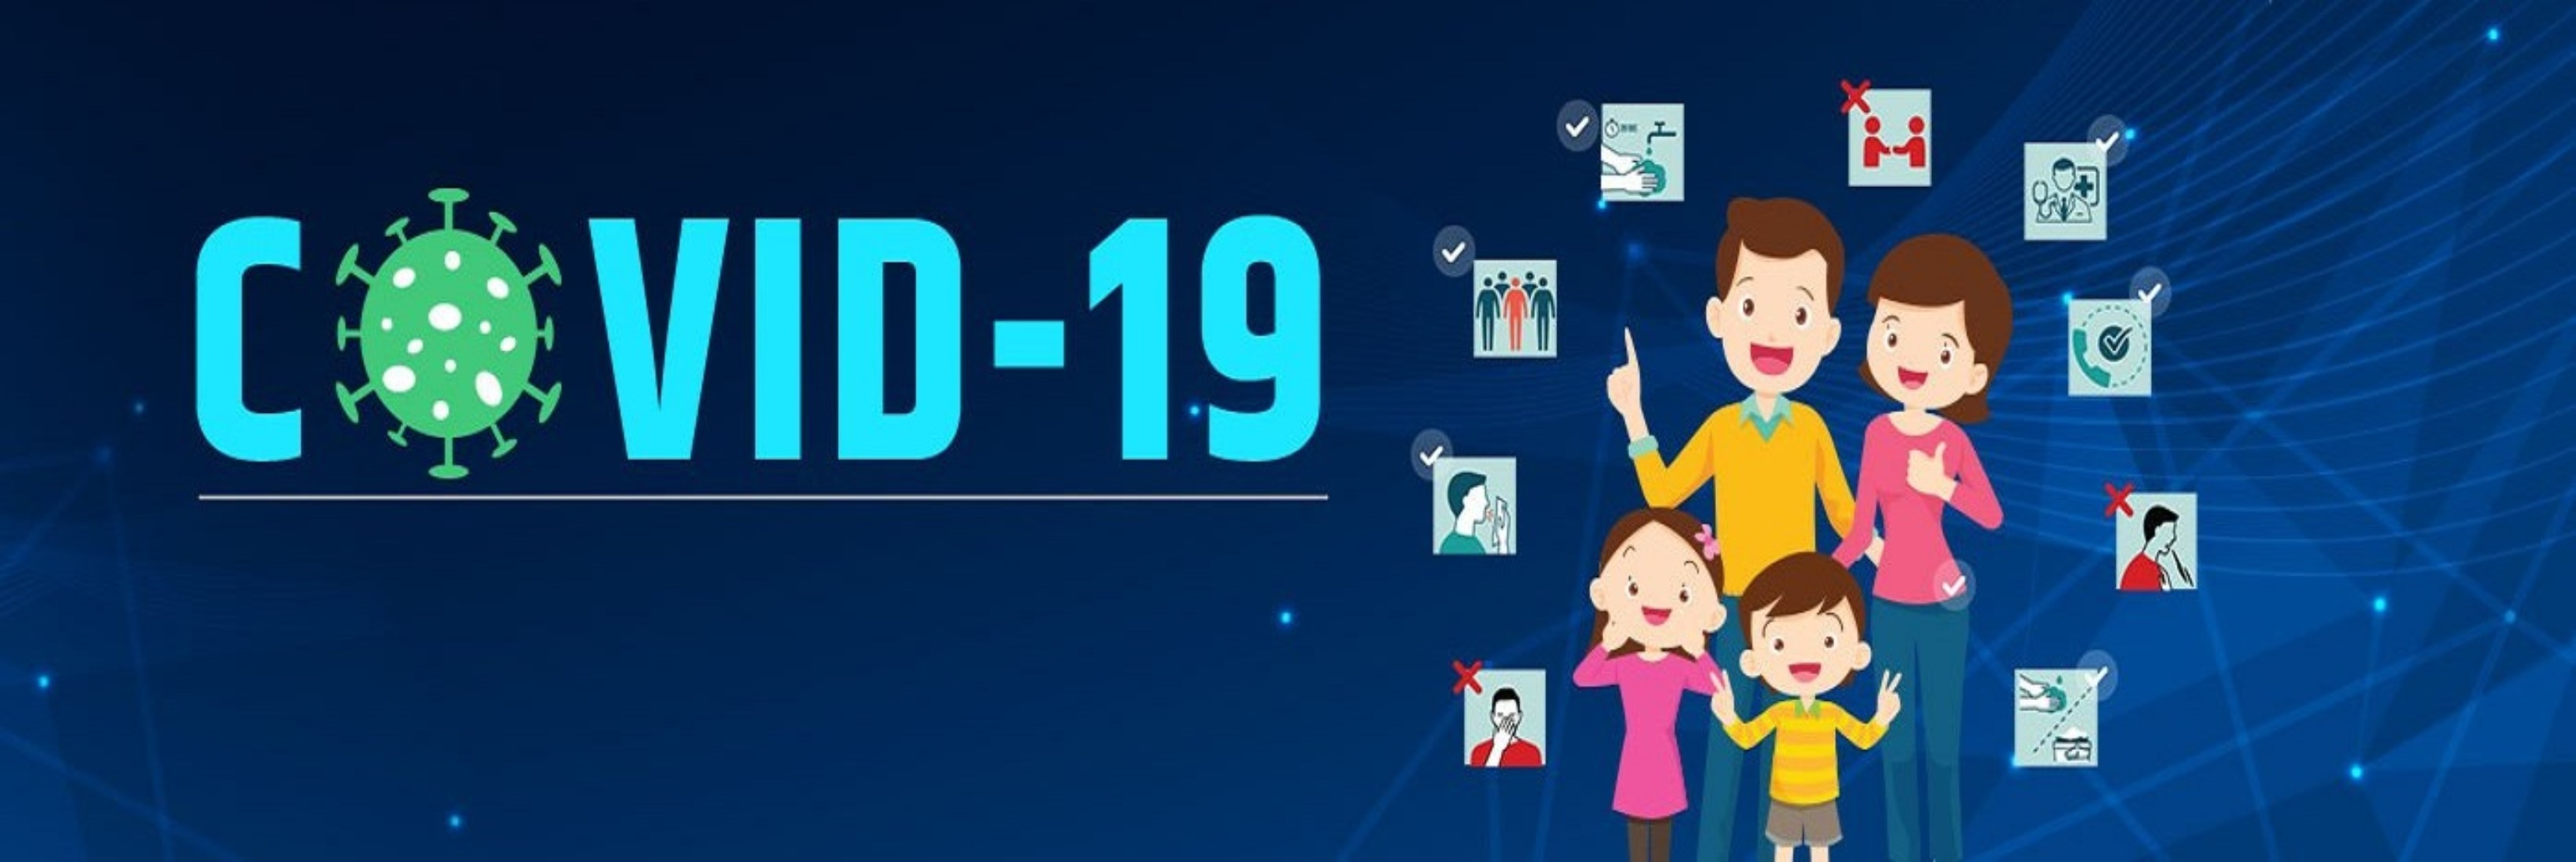

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from pandas_profiling import ProfileReport
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn import preprocessing


# Access Train and Test Dataset

In [ ]:
#Reading CSV files
xtrain = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/train.csv')
xtest = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/test.csv')
xsubmission = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/submission.csv')

# Explore and Processing Dataset

In [ ]:
#Getting information of dataset
xtrain.rename(columns={'Country_Region':'Country'}, inplace=True)
xtest.rename(columns={'Country_Region':'Country'}, inplace=True)

xtrain.rename(columns={'Province_State':'State'}, inplace=True)
xtest.rename(columns={'Province_State':'State'}, inplace=True)

xtrain['Date'] = pd.to_datetime(xtrain['Date'], infer_datetime_format=True)
xtest['Date'] = pd.to_datetime(xtest['Date'], infer_datetime_format=True)

xtrain.info()
xtest.info()


EMPTY_VAL = "EMPTY_VAL"

def fillState(state, country):
    if state == EMPTY_VAL: return country
    return state

In [ ]:
X_xTrain = xtrain.copy()

X_xTrain['State'].fillna(EMPTY_VAL, inplace=True)
X_xTrain['State'] = X_xTrain.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

X_xTrain.loc[:, 'Date'] = X_xTrain.Date.dt.strftime("%m%d")
X_xTrain["Date"]  = X_xTrain["Date"].astype(int)

X_xTrain.head()

X_xTest = xtest.copy()

X_xTest['State'].fillna(EMPTY_VAL, inplace=True)
X_xTest['State'] = X_xTest.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

X_xTest.loc[:, 'Date'] = X_xTest.Date.dt.strftime("%m%d")
X_xTest["Date"]  = X_xTest["Date"].astype(int)

X_xTest.head()

In [ ]:

le = preprocessing.LabelEncoder()

X_xTrain.Country = le.fit_transform(X_xTrain.Country)
X_xTrain['State'] = le.fit_transform(X_xTrain['State'])

X_xTrain.head()

X_xTest.Country = le.fit_transform(X_xTest.Country)
X_xTest['State'] = le.fit_transform(X_xTest['State'])

X_xTest.head()

xtrain.head()
xtrain.loc[xtrain.Country == 'Afghanistan', :]
xtest.tail()

In [ ]:
xtrain1 = X_xTrain[X_xTrain.Target=='ConfirmedCases']
xtrain1.pop('Target')
xtrain1 = xtrain1.rename(columns={'TargetValue':'ConfirmedCases'})

xtrain2 = X_xTrain[X_xTrain.Target=='Fatalities']
xtrain2.pop('Target')
xtrain2 = xtrain2.rename(columns={'TargetValue':'Fatalities'})

xtest1 = X_xTest[X_xTest.Target=='ConfirmedCases']
xtest1.pop('Target')
xtest1 = xtest1.rename(columns={'TargetValue':'ConfirmedCases'})

xtest2 = X_xTest[X_xTest.Target=='Fatalities']
xtest2.pop('Target')
xtest2 = xtest2.rename(columns={'TargetValue':'Fatalities'})

xtest1

In [ ]:
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

In [ ]:
countries = X_xTrain.Country.unique()

xout1 = pd.DataFrame({'ForecastId': [], 'ConfirmedCases': []})

for country in countries:
    states = X_xTrain.loc[X_xTrain.Country == country, :].State.unique()
    # check whether string is nan or not
    for state in states:
        X_xTrain_CS = xtrain1.loc[(xtrain1.Country == country) & (xtrain1.State == state), ['State', 'Country', 'Date', 'ConfirmedCases']]
        
        y1_xTrain_CS = X_xTrain_CS.loc[:, 'ConfirmedCases']
        
        X_xTrain_CS = X_xTrain_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_xTrain_CS.Country = le.fit_transform(X_xTrain_CS.Country)
        X_xTrain_CS['State'] = le.fit_transform(X_xTrain_CS['State'])
        
        X_xTest_CS = xtest1.loc[(xtest1.Country == country) & (xtest1.State == state), ['State', 'Country', 'Date', 'ForecastId']]
        
        X_xTest_CS_Id = X_xTest_CS.loc[:, 'ForecastId']
        X_xTest_CS = X_xTest_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_xTest_CS.Country = le.fit_transform(X_xTest_CS.Country)
        X_xTest_CS['State'] = le.fit_transform(X_xTest_CS['State'])
    


        model = XGBRegressor(n_estimators = 1000 , random_state = 0)
        model.fit(X_xTrain_CS, y1_xTrain_CS)
        preds = model.predict(X_xTest_CS)
        xdata1 = pd.DataFrame({'ForecastId': X_xTest_CS_Id, 'ConfirmedCases': preds})
        xout1 = xout1.append(xdata1)

xout1.reset_index(inplace=True)
xout1 = xout1.rename(columns={'ConfirmedCases':'TargetValue'})
xout1['ForecastId'] = xout1['ForecastId'].astype(int)
xout1

a=xout1.groupby(['ForecastId'])['TargetValue'].quantile(q=0.05).reset_index()
b=xout1.groupby(['ForecastId'])['TargetValue'].quantile(q=0.5).reset_index()
c=xout1.groupby(['ForecastId'])['TargetValue'].quantile(q=0.95).reset_index()

a.columns=['Id','q0.05']
b.columns=['Id','q0.5']
c.columns=['Id','q0.95']
a=pd.concat([a,b['q0.5'],c['q0.95']],1)
a

In [ ]:
sub=pd.melt(a, id_vars=['Id'], value_vars=['q0.05','q0.5','q0.95'])
sub['variable']=sub['variable'].str.replace("q","", regex=False)
sub['ForecastId_Quantile']=sub['Id'].astype(str)+'_'+sub['variable']
sub['TargetValue']=sub['value']
sub=sub[['ForecastId_Quantile','TargetValue']]
sub.reset_index(drop=True,inplace=True)
sub1 = sub.copy()
sub1

In [ ]:
countries = X_xTrain.Country.unique()

xout2 = pd.DataFrame({'ForecastId': [], 'Fatalities': []})

for country in countries:
    states = X_xTrain.loc[X_xTrain.Country == country, :].State.unique()

    # check whether string is nan or not
    for state in states:
        X_xTrain_CS = xtrain2.loc[(xtrain2.Country == country) & (xtrain2.State == state), ['State', 'Country', 'Date', 'Fatalities']]
        
        y1_xTrain_CS = X_xTrain_CS.loc[:, 'Fatalities']
        
        X_xTrain_CS = X_xTrain_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_xTrain_CS.Country = le.fit_transform(X_xTrain_CS.Country)
        X_xTrain_CS['State'] = le.fit_transform(X_xTrain_CS['State'])
        
        X_xTest_CS = xtest2.loc[(xtest2.Country == country) & (xtest2.State == state), ['State', 'Country', 'Date', 'ForecastId']]
        
        X_xTest_CS_Id = X_xTest_CS.loc[:, 'ForecastId']
        X_xTest_CS = X_xTest_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_xTest_CS.Country = le.fit_transform(X_xTest_CS.Country)
        X_xTest_CS['State'] = le.fit_transform(X_xTest_CS['State'])
    


        model = XGBRegressor(n_estimators = 1000 , random_state = 0)
        model.fit(X_xTrain_CS, y1_xTrain_CS)
        preds = model.predict(X_xTest_CS)
        xdata1 = pd.DataFrame({'ForecastId': X_xTest_CS_Id, 'Fatalities': preds})
        xout2 = xout2.append(xdata1)

xout2.reset_index(inplace=True)
xout2 = xout2.rename(columns={'Fatalities':'TargetValue'})
xout2['ForecastId'] = xout2['ForecastId'].astype(int)
xout2

a=xout2.groupby(['ForecastId'])['TargetValue'].quantile(q=0.05).reset_index()
b=xout2.groupby(['ForecastId'])['TargetValue'].quantile(q=0.5).reset_index()
c=xout2.groupby(['ForecastId'])['TargetValue'].quantile(q=0.95).reset_index()

a.columns=['Id','q0.05']
b.columns=['Id','q0.5']
c.columns=['Id','q0.95']
a=pd.concat([a,b['q0.5'],c['q0.95']],1)
a

In [ ]:
sub=pd.melt(a, id_vars=['Id'], value_vars=['q0.05','q0.5','q0.95'])
sub['variable']=sub['variable'].str.replace("q","", regex=False)
sub['ForecastId_Quantile']=sub['Id'].astype(str)+'_'+sub['variable']
sub['TargetValue']=sub['value']
sub=sub[['ForecastId_Quantile','TargetValue']]
sub.reset_index(drop=True,inplace=True)
sub2 = sub.copy()
sub2

In [ ]:
sub = sub1.append(sub2)
sub

In [ ]:
sub.reset_index(drop=True,inplace=True)
sub.to_csv("submission.csv",index=False)
sub.head()